In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import random_split

from torch_geometric.data import Data, DataLoader, Batch

from tqdm import tqdm
import glob
from pathlib import Path
import gzip
import json

from ml.src.model import EdgeModel, GraphTrainer
from ml.src.graph import build_grid_graph, plot_grid_graph
from ml.src.utils import compute_dc_power_flow

# CHOOSE CASE

Number of files: 365
Initial data keys: ['SOURCE', 'Parameters', 'Generators', 'Transmission lines', 'Contingencies', 'Buses', 'Reserves']
Historical data keys: ['Thermal production (MW)/g1', 'Thermal production (MW)/g2', 'Thermal production (MW)/g3', 'Thermal production (MW)/g4', 'Thermal production (MW)/g5', 'Thermal production cost ($)/g1', 'Thermal production cost ($)/g2', 'Thermal production cost ($)/g3', 'Thermal production cost ($)/g4', 'Thermal production cost ($)/g5', 'Is_on/g1', 'Is_on/g2', 'Is_on/g3', 'Is_on/g4', 'Is_on/g5', 'Switch_on/g1', 'Switch_on/g2', 'Switch_on/g3', 'Switch_on/g4', 'Switch_on/g5', 'Switch_off/g1', 'Switch_off/g2', 'Switch_off/g3', 'Switch_off/g4', 'Switch_off/g5', 'objective_value']


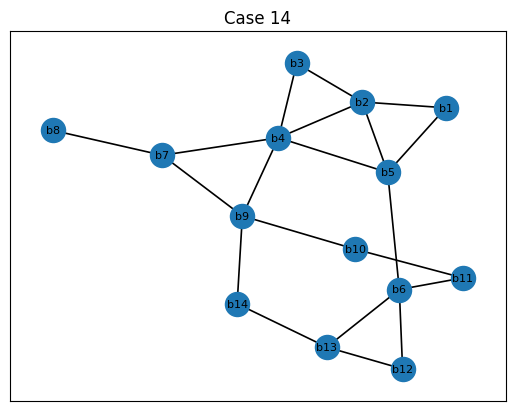

In [3]:
CASE = "case14"

INITIAL_DATA_DIR = Path("cases") / CASE
HIST_DATA_DIR = Path("gurobi_solution_cases") / CASE

print("Number of files:", len(list(HIST_DATA_DIR.glob('*.npz'))))

initial_files = sorted(INITIAL_DATA_DIR.glob("*.json.gz"))
hist_files = sorted(HIST_DATA_DIR.glob("*.npz"))

with gzip.open(initial_files[0], "rt", encoding="utf-8") as gzfile:
    first_initial_data = json.load(gzfile)
    
print("Initial data keys:", list(first_initial_data.keys()))
    
with np.load(hist_files[0], allow_pickle=True) as npzfile:
    first_hist_data = npzfile
print("Historical data keys:", first_hist_data.files)

# Create and plot a graph from the CASE data
G, bus_idx = build_grid_graph(first_initial_data)

plot_grid_graph(G, bus_idx)

In [4]:
# Power flow on each transmission line does not exceed its thermal limits
LIMIT = 5.0

# Statistic data for topology
records = []

for init_f, hist_f in tqdm(zip(initial_files, hist_files), total=len(hist_files)):
    with gzip.open(init_f, "rt", encoding="utf-8") as f:
        data = json.load(f)
        
    buses = data["Buses"]
    lines = data["Transmission lines"]
    gens  = data["Generators"]
    
    n_bus = len(buses)
    n_line = len(lines)
    
    bus_ids = list(buses.keys())
    line_ids = list(lines.keys())
    bus_idx = {bus_id: i for i, bus_id in enumerate(bus_ids)}
    
    # Transmission lines FEATURES (topology) - edge
    edge_index_list = []
    edge_attr_list = []

    for line_id in line_ids:
        line = lines[line_id]
        i = bus_idx[line["Source bus"]]
        j = bus_idx[line["Target bus"]]
        reactance = line["Reactance (ohms)"]
        susceptance = line["Susceptance (S)"]

        edge_index_list.append([i, j])
        edge_attr_list.append([reactance, susceptance])

    edge_index = torch.tensor(edge_index_list).T
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float32)
    
    # Buses features
    x = []

    for bus_id in bus_ids:
        bus = buses[bus_id]
        load = bus.get("Load (MW)")

        mean_load = np.mean(load)
        max_load = np.max(load)
        min_load = np.min(load)
        std_load = np.std(load)

        x.append([mean_load, max_load, min_load, std_load])

    x = torch.tensor(x, dtype=torch.float32)

    # TODO: Calculate power flow, take from historical data
    # with np.load(hist_f, allow_pickle=True) as npzfile:
        # hist_data = npzfile
    
    flows = compute_dc_power_flow(data)
    
    y = (flows >= LIMIT).astype(np.int64)
    y = torch.tensor(y, dtype=torch.float32)
    day_id = init_f.stem 
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.case_id = CASE
    data.day_id  = day_id
    data.edge_id = line_ids 
    records.append(data)

100%|██████████| 365/365 [00:00<00:00, 744.05it/s]


In [5]:
# DATASET
n_total = len(records)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val

train_set, val_set, test_set = random_split(records, [n_train, n_val, n_test])

loader_train = DataLoader(train_set, batch_size=16, shuffle=True)
loader_val = DataLoader(val_set, batch_size=16)
loader_test = DataLoader(test_set, batch_size=n_test)

/Users/grigorii/Library/Python/3.9/lib/python/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# ML model

In [6]:
if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

model = EdgeModel(
    node_in_dim=records[0].x.size(1),
    edge_in_dim=records[0].edge_attr.size(1)
    ).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
bce_loss = nn.BCELoss()
EPOCHS = 100

trainer = GraphTrainer(
    model=model,
    optimizer=optimizer,
    criterion=bce_loss,
    loader_train=loader_train,
    loader_val=loader_val,
    epochs = EPOCHS,
    device = DEVICE
    )

trainer.fit()

Using device: mps
Epoch 000 | loss=0.7328 | acc=0.676 | prec=0.880 | rec=0.686 | f1=0.771
Epoch 001 | loss=0.4709 | acc=0.819 | prec=0.931 | rec=0.834 | f1=0.880
Epoch 002 | loss=0.4051 | acc=0.798 | prec=0.929 | rec=0.808 | f1=0.864
Epoch 003 | loss=0.3799 | acc=0.836 | prec=0.931 | rec=0.858 | f1=0.893
Epoch 004 | loss=0.3604 | acc=0.839 | prec=0.933 | rec=0.859 | f1=0.895
Epoch 005 | loss=0.3444 | acc=0.880 | prec=0.941 | rec=0.906 | f1=0.923
Epoch 006 | loss=0.3294 | acc=0.902 | prec=0.952 | rec=0.923 | f1=0.937
Epoch 007 | loss=0.3159 | acc=0.909 | prec=0.955 | rec=0.930 | f1=0.942
Epoch 008 | loss=0.3037 | acc=0.920 | prec=0.970 | rec=0.929 | f1=0.949
Epoch 009 | loss=0.2924 | acc=0.917 | prec=0.973 | rec=0.921 | f1=0.946
Epoch 010 | loss=0.2815 | acc=0.914 | prec=0.973 | rec=0.917 | f1=0.944
Epoch 011 | loss=0.2705 | acc=0.915 | prec=0.973 | rec=0.919 | f1=0.945
Epoch 012 | loss=0.2593 | acc=0.916 | prec=0.972 | rec=0.921 | f1=0.946
Epoch 013 | loss=0.2493 | acc=0.929 | prec=0.9

In [22]:
import random
from pathlib import Path, PurePath
import json

batch = next(iter(loader_val))
graph = random.choice(batch.to_data_list()).to(DEVICE)

model.eval()
with torch.no_grad():
    y_prob = model(graph.x, graph.edge_index, graph.edge_attr).cpu()

th = 0.7
y_pred = (y_prob > th).int()


# line_dict = {lid: (bit) for lid, bit in zip(graph.edge_id, y_pred.tolist())}
line_dict = {lid: int(1 - bit)            # меняем 0 ↔ 1
             for lid, bit in zip(graph.edge_id, y_pred.tolist())}

payload = {
    "case": graph.case_id,
    "day":  graph.day_id,
    "line_pruning": line_dict
}

out = Path(f"constraints_line_{graph.case_id}_{PurePath(graph.day_id).stem}.json")
out.write_text(json.dumps(payload, indent=2), encoding="utf-8")
print("Saved →", out.resolve())


Saved → /Users/grigorii/Desktop/SCUC/SCUC_problem/SCUCa/constraints_line_case14_2017-06-24.json


In [20]:
line_dict

{'l1': 0,
 'l2': 0,
 'l3': 0,
 'l4': 0,
 'l5': 0,
 'l6': 0,
 'l7': 0,
 'l8': 0,
 'l9': 0,
 'l10': 0,
 'l11': 0,
 'l12': 0,
 'l13': 0,
 'l14': 1,
 'l15': 0,
 'l16': 1,
 'l17': 0,
 'l18': 1,
 'l19': 1,
 'l20': 1}

In [21]:
y_pred.tolist()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]

In [11]:
line_dict

{'l1': 0,
 'l2': 0,
 'l3': 1,
 'l4': 1,
 'l5': 0,
 'l6': 1,
 'l7': 0,
 'l8': 0,
 'l9': 0,
 'l10': 0,
 'l11': 0,
 'l12': 0,
 'l13': 0,
 'l14': 0,
 'l15': 0,
 'l16': 0,
 'l17': 0,
 'l18': 0,
 'l19': 0,
 'l20': 0}

In [10]:
y_pred

tensor([0.9994, 0.9977, 1.0000, 1.0000, 1.0000, 1.0000, 0.9941, 0.9999, 0.9420,
        0.9797, 0.5657, 0.9693, 0.9749, 0.0393, 0.9997, 0.4234, 0.9954, 0.0409,
        0.0338, 0.1715])

In [8]:
batch = next(iter(loader_val))
i = np.random.randint(0, batch.num_graphs - 1)
single_graph = Batch.from_data_list([batch.get_example(i)]).to(DEVICE)

print(f"⚡  Graph info →  CASE: {single_graph.case_id},   DAY: {single_graph.day_id}")

model.eval()
with torch.no_grad():
    y_pred = model(single_graph.x, single_graph.edge_index, single_graph.edge_attr).cpu()
    y_true = single_graph.y.cpu()

threshold = 0.7
y_bin = (y_pred > threshold).int()
y_bin, y_true

print("Predicted:", y_pred.tolist())
print("True     :", y_true.tolist())
print(sum(y_bin)/sum(y_true))  # Accuracy metric

    #   ( (y_pred & y_true).sum().item() / max(1, y_true.sum().item()) ))

⚡  Graph info →  CASE: ['case14'],   DAY: ['2017-04-13.json']
Predicted: [0.999376118183136, 0.9977452158927917, 1.0, 1.0, 0.9999717473983765, 1.0, 0.9941180944442749, 0.9999126195907593, 0.9420437812805176, 0.9796971678733826, 0.5656982660293579, 0.9692999720573425, 0.9749167561531067, 0.039265818893909454, 0.9997473359107971, 0.4233649969100952, 0.9953832030296326, 0.0408671498298645, 0.03383460268378258, 0.17145630717277527]
True     : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
tensor(1.)


In [9]:
from pathlib import Path, PurePath
import json

line_dict = {lid: int(bit) for lid, bit in zip(graph.edge_id, y_pred.tolist())}

payload = {
    "case": graph.case_id,
    "day":  graph.day_id,
    "line_pruning": line_dict
}

out = Path(f"pruning_{graph.case_id}_{PurePath(graph.day_id).stem}.json")
out.write_text(json.dumps(payload, indent=2), encoding="utf-8")
print("Saved →", out.resolve())


Saved → /Users/grigorii/Desktop/SCUC/SCUC_problem/SCUCa/pruning_case14_2017-07-20.json


/var/folders/6v/trq398m145gbsl8204wvnzvh0000gn/T/ipykernel_41640/3601773704.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


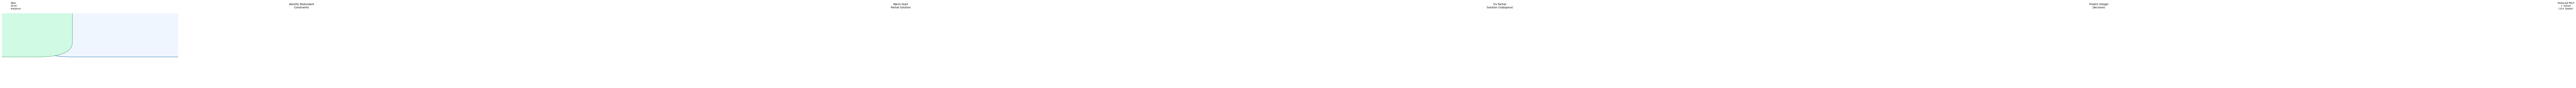

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure
fig, ax = plt.subplots(figsize=(12, 5))
ax.axis('off')

# Box specs
box_w = 2.6
box_h = 1.0
y_level = 0.6

labels = [
    "Identify Redundant\nConstraints",
    "Warm‑Start\nPartial Solution",
    "Fix Partial\nSolution (Subspace)",
    "Predict Integer\nDecisions"
]

boxes = []
for i, label in enumerate(labels):
    x = 0.4 + i * (box_w + 0.8)
    rect = patches.FancyBboxPatch(
        (x, y_level), box_w, box_h,
        boxstyle="round,pad=0.2", linewidth=1.5, edgecolor="steelblue", facecolor="#EFF6FF"
    )
    ax.add_patch(rect)
    ax.text(x + box_w / 2, y_level + box_h / 2, label, ha='center', va='center', fontsize=10)
    boxes.append(rect)

# Arrows
for i in range(len(labels) - 1):
    x_start = boxes[i].get_x() + box_w
    x_end = boxes[i+1].get_x()
    y = y_level + box_h / 2
    ax.annotate(
        "",
        xy=(x_end - 0.05, y), xytext=(x_start + 0.05, y),
        arrowprops=dict(arrowstyle="->", linewidth=1.4)
    )

# Input and output boxes
in_rect = patches.FancyBboxPatch((-0.1, y_level), 0.3, box_h,
                                 boxstyle="round,pad=0.2", facecolor="#D1FAE5", edgecolor="seagreen")
ax.add_patch(in_rect)
ax.text(0.05, y_level + box_h / 2, "New\nSCUC\nInstance", ha="left", va="center", fontsize=9)

out_rect = patches.FancyBboxPatch((boxes[-1].get_x() + box_w + 0.5, y_level), 1.7, box_h,
                                  boxstyle="round,pad=0.2", facecolor="#FDE68A", edgecolor="darkorange")
ax.add_patch(out_rect)
ax.text(out_rect.get_x() + 0.85, y_level + box_h / 2,
        "Reduced MILP\n+ Solver\n(10× faster)", ha="center", va="center", fontsize=9)

plt.tight_layout()

